In [ ]:
# Install shap if not available
import sys
!{sys.executable} -m pip install shap

# What does this model do?

**Predicts utilization counts for each category (e.g., PCP visits, Rx fills, inpatient stays).**

These counts will be multiplied by their respective insurance policy costs.

Model is trained on MEPS data: https://meps.ahrq.gov/mepsweb/data_stats/download_data_files.jsp

Lots of this research is based off this textbook from my undergrad: https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html

Model v3 will be a Poisson regression model to enhance explainability.

# Imports

In [69]:
import pandas as pd
import polars as pl # using polars library for large .xlsx files
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

import joblib

# Load MEPS Data

ChatGPT: Use consolidated from year t and counts from year t+1 if you're predicting future utilization (prospective), which is better for real-world use.

We are using consolidated from 2022 and counts from 2023.

## Consolidated Data

**Skip if h243.xlsx has already been converted to .csv and .parquet.**

In [ ]:
# Define schema for problematic columns
schema_overrides = {
    'HRWG53X': pl.Float64,  # Use float instead of int for decimal values
    # Add other problematic columns as needed
}

df = pl.read_excel(
    "/Users/orenj/Desktop/Projects/open-coverage/python-models/data/h243.xlsx",
    schema_overrides=schema_overrides
)

df.head()

Convert to faster data formats for later use

In [ ]:
df.write_csv("/Users/orenj/Desktop/Projects/open-coverage/python-models/data/h243.csv")  # Much faster for future loads
df.write_parquet("/Users/orenj/Desktop/Projects/open-coverage/python-models/data/h243.parquet")  # Even faster, compressed

Load MEPS Consolidated File (person-level features + target)

In [14]:
df_cons = pd.read_parquet("/Users/orenj/Desktop/Projects/open-coverage/python-models/data/MEPS/2022-consolidated/h243.parquet")

df_cons.head()

,DUID,PID,DUPERSID,PANEL,DATAYEAR,FAMID31,FAMID42,FAMID53,FAMID22,FAMIDYR,...,RXOSR22,RXPTR22,RXOTH22,PERWT22F,FAMWT22F,FAMWT22C,SAQWT22F,DIABW22F,VARSTR,VARPSU
0,2460002,101,2460002101,24,2022,A,A,A,A,A,...,0,0,0,5728.309495,5232.211986,5232.211986,3994.687140,6034.636755,2082,1
1,2460006,101,2460006101,24,2022,A,A,A,A,A,...,0,0,0,15648.881461,16017.881691,16017.881691,0.000000,0.000000,2001,4
2,2460006,102,2460006102,24,2022,A,A,A,A,A,...,0,0,0,14123.720178,16017.881691,12580.731740,0.000000,0.000000,2001,4
3,2460010,101,2460010101,24,2022,A,A,A,A,A,...,0,5288,299,16982.054917,21905.758877,21905.758877,0.000000,0.000000,2038,3
4,2460018,101,2460018101,24,2022,A,A,A,A,A,...,0,10,0,10682.619947,11344.291012,11344.291012,17152.439412,0.000000,2041,1


## Aggregate Event Files

Load data files for **Counts per Person**

In [15]:
event_files = {
    "pcp_visits": "/Users/orenj/Desktop/Projects/open-coverage/python-models/data/MEPS/2023-counts/h248g.xlsx",            # Office-based visits
    "outpatient_visits": "/Users/orenj/Desktop/Projects/open-coverage/python-models/data/MEPS/2023-counts/h248f.xlsx",     # Outpatient visits
    "er_visits": "/Users/orenj/Desktop/Projects/open-coverage/python-models/data/MEPS/2023-counts/h248e.xlsx",             # Emergency Room visits
    "inpatient_admits": "/Users/orenj/Desktop/Projects/open-coverage/python-models/data/MEPS/2023-counts/h248d.xlsx",      # Inpatient stays
    "home_health_visits": "/Users/orenj/Desktop/Projects/open-coverage/python-models/data/MEPS/2023-counts/h248h.xlsx",    # Home health visits
    "rx_fills": "/Users/orenj/Desktop/Projects/open-coverage/python-models/data/MEPS/2023-counts/h248a.xlsx",              # Prescription fills
    "dental_visits": "/Users/orenj/Desktop/Projects/open-coverage/python-models/data/MEPS/2023-counts/h248b.xlsx",         # Dental visits
    "equipment_purchases": "/Users/orenj/Desktop/Projects/open-coverage/python-models/data/MEPS/2023-counts/h248c.xlsx"    # Medical equipment/supplies
}

# Count records per DUPERSID for each event type
counts_dict = {}
for feat_name, filepath in event_files.items():
    # Use pandas with usecols parameter (which works correctly)
    df_evt = pd.read_excel(filepath, usecols=["DUPERSID"])
    
    # Count occurrences per DUPERSID
    counts = df_evt.groupby("DUPERSID").size().rename(feat_name)
    counts_dict[feat_name] = counts

# Merge all counts into a single DataFrame
counts_df = (
    pd.concat(counts_dict.values(), axis=1)
      .fillna(0)
      .reset_index()
)

## Merge consolidated with counts

Doing a left join on DUPERSID so everyone is included in the dataset. Also need to predict those with zero events.

DUPERSID: AHRQ‑generated person identifier (derived from dwelling/unit and person IDs). It uniquely identifies a respondent within a year, and from 2018 onward it’s constructed to be unique across panels/year.

In [16]:
df = (
    df_cons
      .merge(counts_df, on="DUPERSID", how="left")
      .fillna(0)
)
df.head()

,DUID,PID,DUPERSID,PANEL,DATAYEAR,FAMID31,FAMID42,FAMID53,FAMID22,FAMIDYR,...,VARSTR,VARPSU,pcp_visits,outpatient_visits,er_visits,inpatient_admits,home_health_visits,rx_fills,dental_visits,equipment_purchases
0,2460002,101,2460002101,24,2022,A,A,A,A,A,...,2082,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2460006,101,2460006101,24,2022,A,A,A,A,A,...,2001,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2460006,102,2460006102,24,2022,A,A,A,A,A,...,2001,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2460010,101,2460010101,24,2022,A,A,A,A,A,...,2038,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2460018,101,2460018101,24,2022,A,A,A,A,A,...,2041,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df.shape

(22431, 1428)

# Select Features and Target Variables

Reduced feature set to 10 from model v2 after doing SHAP value analysis. Below are the features and their descriptions.

| **Category**               | **Feature**                 | **Variable Name**                  | **Description**                                                    |
| -------------------------- | --------------------------- | ---------------------------------- | ------------------------------------------------------------------ |
| **Identifiers**            | Person ID                   | `person_id`                        | Unique person identifier (for merges)                              |
| **Demographics**           | Age                         | `age_years_2022`                   | Age as of 12/31/2022 (imputed)                                     |
|                            | Sex                         | `gender`                           | Survey-reported gender (1 = Male, 2 = Female)                      |
|                            | Race/Ethnicity              | `race_ethnicity`                   | Detailed race and ethnicity categories                             |
|                            | Region                      | `census_region`                    | Census region (Northeast, Midwest, South, West)                    |
| **Socioeconomic**          | Employment Status           | `employment_status`                | Employed full-/part-time vs. unemployed/inactive                   |
|                            | Family Size                 | `family_size`                      | Number of people in the family unit                                |
| **Access & Utilization**   | Usual Source of Care        | `has_usual_source_of_care`         | Has a usual source of medical care                                 |
| **Behaviors & Lifestyle**  | BMI                         | `bmi`                              | Body Mass Index (>17) from Round 4/5                               |
| **Functional & Cognitive** | Difficulty Walking/Stairs   | `difficulty_walking_stairs`        | Serious difficulty walking or climbing stairs                      |
|                            | Any Activity Limitation     | `any_activity_limitation`          | Any limitation in usual activities due to health                   |
|                            | Psychological Distress (K6) | `k6_distress_score`                | Kessler 6-item psychological distress score (0–24)                 |
| **Outcome**                | Total Expenditures (target) | `total_expenditures_2022`          | Sum of all payments in 2022                                        |


### Rename input variables

In [64]:
# Rename MEPS columns to descriptive names
df.rename(columns={
    "DUPERSID": "person_id",
    "AGE22X": "age_years_2022",
    "ADSEX42": "gender",
    "RACETHX": "race_ethnicity",
    "HISPNCAT": "hispanic_origin_category",
    "REGION22": "census_region",
    "MSA22": "metro_status",
    "EDUCYR": "education_years",
    "HIDEG": "highest_degree_achieved",
    "FAMINC22": "family_income_2022",
    "POVLEV22": "poverty_level_pct",
    "POVCAT22": "poverty_category",
    "EMPST42": "employment_status",
    "HOUR42": "hours_worked_per_week",
    "OCCCAT42": "occupation_industry_category",
    "FAMSZE22": "family_size",
    "MARRY22X": "marital_status",
    "SPOUIN22": "spouse_in_household",
    "INSCOV22": "insurance_coverage_type",
    "HAVEUS42": "has_usual_source_of_care",
    "LOCATN42": "usual_care_location_type",
    "AFRDCA42": "delayed_care_due_to_cost",
    "DLAYPM42": "delayed_prescription_due_to_cost",
    "FOODST22": "received_snap",
    "FOODVL22": "snap_benefit_value_2022",
    "ADBMI42": "bmi",
    "ADOSTP42": "smoking_frequency",
    "ADASKALC42": "alcohol_consumption_frequency",
    "ADDAYEXER42": "exercise_days_per_week",
    "HWELLSPK": "english_proficiency",
    "BORNUSA": "us_born_flag",
    "YRSINUS": "years_in_us",
    "LFTDIF31": "difficulty_lifting_carrying",
    "DFWLKC42": "difficulty_walking_stairs",
    "ACTLIM31": "any_activity_limitation",
    "COGLIM31": "cognitive_limitation",
    "K6SUM42": "k6_distress_score",
    "ADHOPE42": "hopelessness_frequency_30d",
    "ADSAD42": "sadness_frequency_30d",
    "TOTEXP22": "total_expenditures_2022"
}, inplace=True)

### Combine datasets

In [65]:
feature_cols = [
    "gender",
    "race_ethnicity",
    "census_region",
    "any_activity_limitation",
    "employment_status",
    "difficulty_walking_stairs",
    "k6_distress_score",
    "age_years_2022",
    "family_size",
    "bmi",
]

count_targets = [
    "pcp_visits", "outpatient_visits", "er_visits",
    "inpatient_admits", "home_health_visits",
    "rx_fills", "dental_visits", "equipment_purchases"
]

X = df[feature_cols]
y = df[count_targets].clip(lower=0)

# Exploratory Analysis

About the data:
The Medical Expenditure Panel Survey takes data from the CDC's National Health Interview Survey, a well-sampled survey.

We know from v2 that there are no null values in the raw feature MEPS data because there were reserved negative values indicating reasons for a null value. These will be fixed in the preprocessing step.

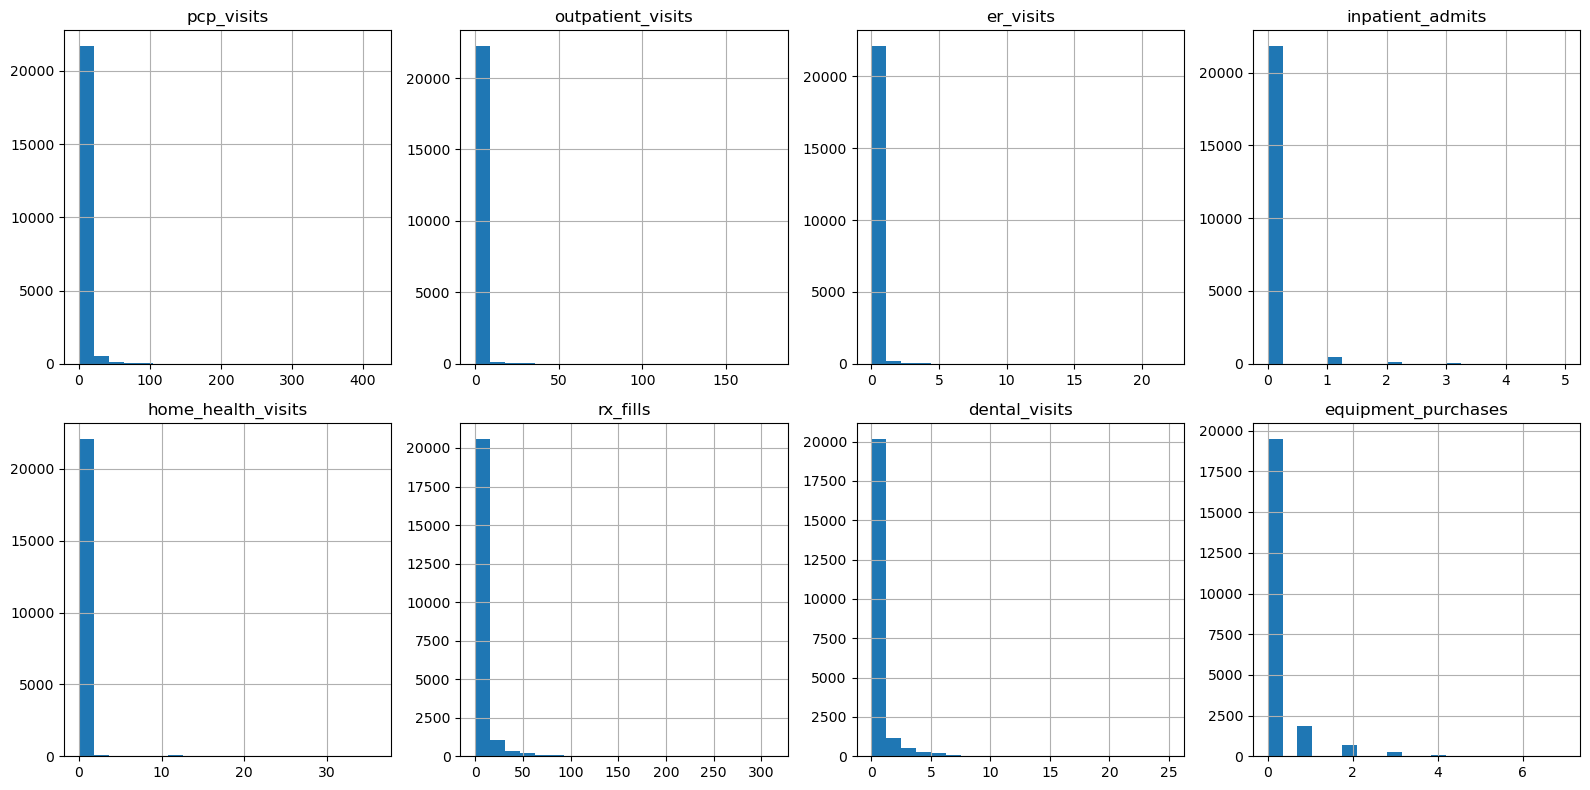

In [ ]:
count_targets = [
    "pcp_visits", "outpatient_visits", "er_visits",
    "inpatient_admits", "home_health_visits",
    "rx_fills", "dental_visits", "equipment_purchases"
]

# this will create a 2×4 grid of histograms
df[count_targets].hist(
    bins=20,                      # adjust bin count as you like
    figsize=(16, 8),              # overall figure size
    layout=(2, 4),                # 2 rows × 4 columns
    sharex=False, sharey=False    # each plot gets its own axes limits
)
plt.tight_layout()
plt.show()

**Many patients reported no visits or rx fills or equipment purchases. A few patients have a large number.** This is a pattern often found with distributions of counts of rare events. Therefore, Poisson regression should be used to model our data.

Poisson random variables are often used to represent counts (e.g. visits/rx fills/purchases) per unit of time or space (one year).

# Preprocess Data

## Train/Test Split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Preprocessor for Features

The MEPS dataset has reserved negative codes to indicate different reasons for null values instead of just leaving the observation null. For v2 I will just convert these negative codes to null. This can be addressed in a later model version. Ex. -7 = respondant refused to answer the question, -8 = respondant did not know the information

In [66]:
# All negative “not-real” answers in the 2022 Consolidated PUF
MEPS_2022_RESERVED = {
    -1:  "inapplicable",
    -2:  "determined_prev_round",
    -7:  "refused",
    -8:  "dont_know_or_not_ascertained",
    -10: "hourly_wage_topcode",        # wage-only variables
    -13: "initial_wage_imputed",       # wage-only variables
    -15: "cannot_be_computed"
}
NEG_CODES = list(MEPS_2022_RESERVED.keys())

def neg_to_nan(X: pd.DataFrame) -> pd.DataFrame:
    """Replace MEPS reserved negative codes with NaN."""
    return X.replace(NEG_CODES, np.nan)

nanifier = FunctionTransformer(neg_to_nan, feature_names_out="one-to-one") # convert codes to NaN

Process categories using one hot encoding.

In [67]:
# 1. List your categorical columns
categorical_cols = [
    # Demographics
    "gender",
    "race_ethnicity",
    "census_region",
    "any_activity_limitation",
    "employment_status",
    "difficulty_walking_stairs",
    "k6_distress_score",
    "chronic_condition_count"
    # (you can add more here if you treat them as categorical)
]

# 2. List your numerical columns
numeric_cols = [
    "age_years_2022",
    "family_size",
    "bmi"
]

# 3. Build a little pipeline just for categoricals
categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(      # not imputing NaNs because HistGradientBoostingRegressor natively handles them; change if algorithm changes
        handle_unknown="ignore",   # don't crash if new categories appear in test
        sparse_output=False,             # return a dense array (needed for shap, etc.)
        drop="if_binary"          # drop one level for binary vars to avoid collinearity
    ))
])

# 4. Build a little pipeline just for numerics
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

# 5. Hook it into a ColumnTransformer (you’d add your numeric step(s) too)
preprocessor = ColumnTransformer([
    ("cat", categorical_transformer, categorical_cols),
    ("num", numeric_transformer, numeric_cols)
],
    remainder="passthrough"   # if you have any extras you’re just passing through
)

# Modelling

## Checking Poisson regression assumptions (critical)

**4 Model Assumptions:**

1. **Poisson Response:** variable $\lambda$ is a count per unit of time/space ($\lambda$ = visits/Rxs/purchases per year)
2. **Independence:** observations must be independent of each other
3. **Mean = Variace:** variance increases for each increase of count
4. **Linearity:** $log(\lambda)$ must be a linear function of X

Assumption 1 is met so we can procede to measuring independence.

# Model Evaluation

## Evaluate Each Count Model

In [14]:
metrics = []
for target in count_targets:
    mae = mean_absolute_error(y_test[target], preds[target])
    rmse = root_mean_squared_error(y_test[target], preds[target])
    metrics.append({
        "feature": target,
        "MAE": mae,
        "RMSE": rmse
    })

metrics_df = pd.DataFrame(metrics).set_index("feature")
print("Count Models Evaluation (per-category):")
print(metrics_df)

Count Models Evaluation (per-category):
                          MAE       RMSE
feature                                 
pcp_visits           3.853706   8.767582
outpatient_visits    0.675180   3.600926
er_visits            0.145886   0.420662
inpatient_admits     0.070335   0.237845
home_health_visits   0.275654   1.761036
rx_fills             5.763608  12.988660
dental_visits        0.589623   1.105232
equipment_purchases  0.339166   0.607119


## Predict counts for a synthetic user

For testing missing data use 'np.nan' instead of the value.

In [ ]:
# Define realistic synthetic data for one individual
synthetic_user = {
    # Identifiers
    "person_id": 99999999,

    # Demographics
    "age_years_2022": 57,
    "gender": np.nan,                      # Female
    "race_ethnicity": 3,             # Black/African American
    "hispanic_origin_category": -1,  # Not Hispanic
    "census_region": 3,              # South
    # "metro_status": 1,             # In MSA

    # Socioeconomic
    "education_years": 12,
    "highest_degree_achieved": 3,    # High school graduate
    "family_income_2022": 32000,
    "poverty_level_pct": 140,        # 140% of FPL
    "poverty_category": 2,           # 100–199%
    "employment_status": 2,          # Unemployed
    "hours_worked_per_week": 0,
    "occupation_industry_category": -1,  # Not applicable / unemployed
    "family_size": 3,
    "marital_status": 2,             # Widowed
    "spouse_in_household": 2,        # No spouse in household

    # Access & Utilization
    "insurance_coverage_type": 2,          # Public only (e.g., Medicaid)
    "has_usual_source_of_care": 1,         # Has usual source of care
    "usual_care_location_type": 2,         # Clinic/health center
    "delayed_care_due_to_cost": 1,         # Could not afford care
    "delayed_prescription_due_to_cost": 1, # Delayed meds due to cost
    "received_snap": 1,                    # Received food stamps
    "snap_benefit_value_2022": 1500,

    # Behaviors & Lifestyle
    "bmi": 34.2,                         # Obese
    "smoking_frequency": 2,             # Some days
    "alcohol_consumption_frequency": 3, # <4 times/week
    "exercise_days_per_week": 1,        # 1 day/week
    "english_proficiency": 4,           # Very well
    "us_born_flag": 1,                  # Born in US
    "years_in_us": -1,                  # N/A (born in US)

    # Functional & Cognitive
    "difficulty_lifting_carrying": 1,       # Yes, difficulty lifting
    "difficulty_walking_stairs": 2,         # No difficulty walking
    "any_activity_limitation": 1,           # Yes, limited activities
    "cognitive_limitation": 2,              # No cognitive limitations
    "k6_distress_score": 9,                 # Moderate psychological distress
    "hopelessness_frequency_30d": 3,        # Some of the time
    "sadness_frequency_30d": 3,             # Some of the time

    # Health Status
    # "chronic_condition_count": 4,        # Has multiple chronic conditions

    # Outcome (for training)
    "total_expenditures_2022": 18934.65     # Total expenditures in 2022 (USD)
}

# Create DataFrame with the synthetic individual
synthetic_df = pd.DataFrame([synthetic_user])

# Make predictions using the trained models
predictions = {}
for target in count_targets:
    # Use the trained model to predict
    pred_value = models[target].predict(synthetic_df)[0]
    predictions[target] = max(0, round(pred_value))  # Ensure non-negative integers

# Create predictions DataFrame
predictions_df = pd.DataFrame([predictions])

print("Predicted Healthcare Utilization Counts:")
display(predictions_df)

# Feature Analysis